In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne

## Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [11]:
def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [12]:
targets = 40

def print_graphs(data):
    for i in range(0, targets, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, targets, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, targets, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [13]:
data = np.load("../../datasets/beta/data.npy")

print(data.shape)


(160, 64, 750)


Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

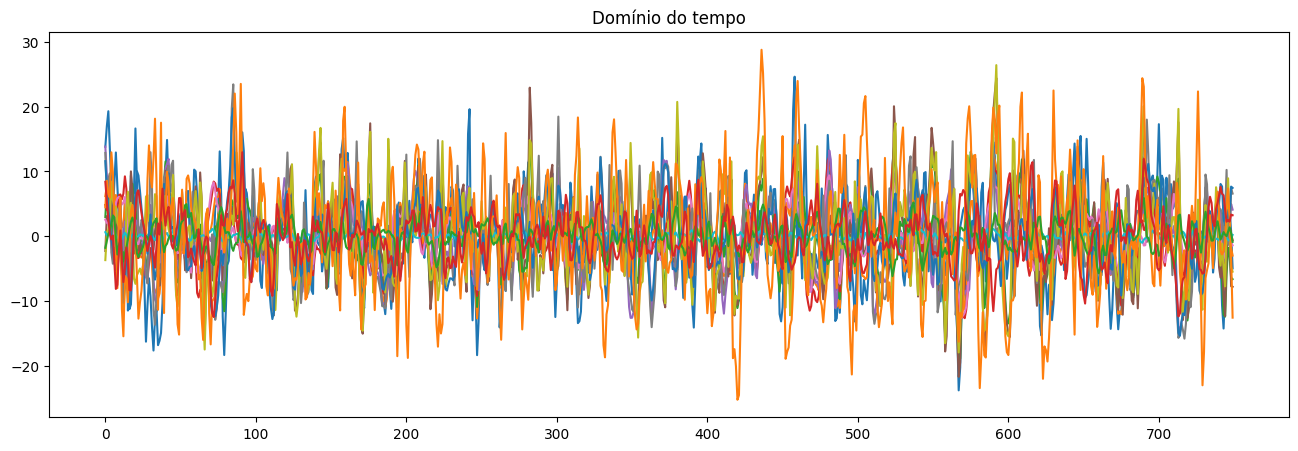

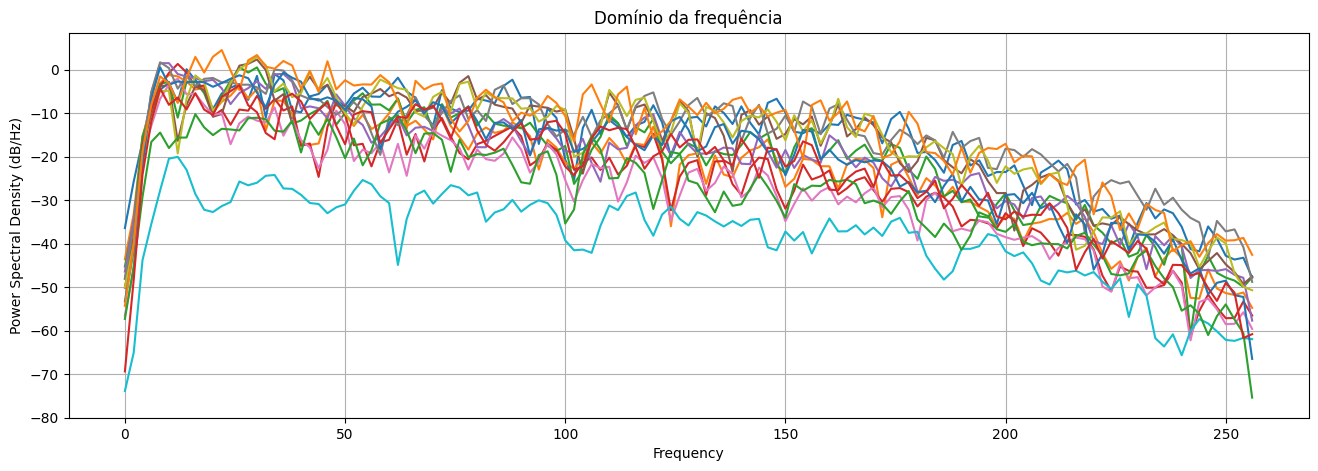

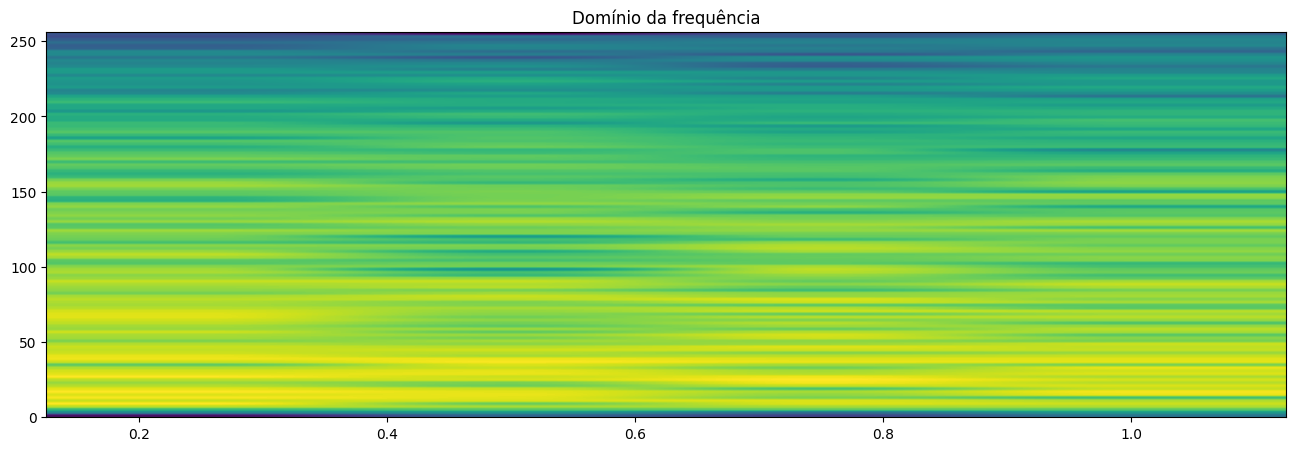

In [14]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data[0])

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [16]:
# criação de um objeto "info"
n_channels = 64
sfreq = 512
ch_names = [
    "Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "FC5", "FC1", "FC2",
    "FC6", "T7", "C3", "Cz", "C4", "T8", "TP9", "CP5", "CP1", "CP2",
    "CP6", "TP10", "P7", "P3", "Pz", "P4", "P8", "PO9", "O1", "Oz",
    "O2", "PO10", "AF7", "AF3", "AF4", "AF8", "F5", "F1", "F2", "F6",
    "FC3", "FCz", "FC4", "C5", "C1", "C2", "C6", "CP3", "CPz", "CP4",
    "P5", "P1", "P2", "P6", "PO3", "POz", "PO4", "I1", "Iz", "I2",
    "A1", "A2", "EX1", "EX2"
]
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)


best = ['P6', 'PO3']

[[-2.88368668  1.58535045  7.33232734 ...  5.24451932  5.09337683
   2.87662142]
 [-2.77708189 -2.66574103  0.64439782 ...  5.61957061  4.72914814
   7.11681236]
 [ 0.24897569 -2.99810806 -1.80046696 ...  7.31651142  5.18136822
   6.15089923]
 ...
 [10.65364796 -4.88542883 -3.47552854 ... 11.61218265 20.09516274
  -5.30596196]
 [ 7.72799507 -7.14001206 -1.63718897 ...  2.98275839 20.01398525
   0.26228384]
 [ 3.85855586 -9.64411322 11.05430949 ... -3.87456468 28.17637252
   1.26092714]]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../../datasets/beta/labels.npy")
unique_labels = sorted(set(labels))
event_dict = {str(value): index  for index, value in enumerate(unique_labels)}
labels.shape

(160,)

In [ ]:
# data : array, shape (n_epochs, n_channels, n_times)
# data_correct = data.reshape(40, n_channels, data.shape[2])
data_correct = data

print(data_correct.shape[1])
print(len(info["ch_names"]))

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(160, dtype=int),
    le.fit_transform(labels))
)

# print(events.shape)

mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
filtered_mne_data = mne_data.filter(6, 18)
filtered_mne_data.save("beta.fif", overwrite=True)

64
64
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 6 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 845 samples (1.650 s)



/tmp/ipykernel_30329/352620586.py:19: RuntimeWarning: filter_length (845) is longer than the signal (750), distortion is likely. Reduce filter length or filter a longer signal.
  filtered_mne_data = mne_data.filter(6, 18)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 3041 tasks    

Overwriting existing file.


[Parallel(n_jobs=1)]: Done 9521 tasks      | elapsed:    2.1s
/tmp/ipykernel_30329/352620586.py:20: RuntimeWarning: This filename (beta.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  filtered_mne_data.save("beta.fif", overwrite=True)


In [ ]:

# import warnings
# warnings.filterwarnings('ignore')

# for i in range(len(mne_data)):
#     # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
#     view = mne_data[i].compute_psd(method='multitaper', fmin=0, fmax=40,
#                                    verbose=False)
#     view.plot(show=False)
#     print()
#     plt.title('Domínio da frequência')
#     plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
#                 color='green')
#     plt.show()
# print()
